# Importing the classifier pickle
NOTE: pickle must contain the trained __classifier__, not just the model.

In [1]:
import os
import math
import json
import pickle
import numpy as np
import statistics as stats

from sklearn import tree
from pandas import DataFrame
from matplotlib import pyplot as plt

# ------ Fill this in to specify which pickle should be opened ------
# --- NOTE: should include full path and filename but NO extension ---
file = "stored_models/trained_classifiers/rf/rf-head-16-cdiac_multilabel_gt_copy.csv-2022-04-17-09.10.27"
# --------------------------------------------------------------

byte_count = int(file.split("/")[-1].split("-")[2])

classifier_path = f"{file}.pkl"
info_metrics_path = f"{file}-info-{byte_count}Bytes.json"

info_metrics = json.load(open(info_metrics_path))

# os.chdir('../XtractPredictor/')
classifier = pickle.load(open(classifier_path, "rb"))
# os.chdir('../xtract-research-notebooks/')

for key in info_metrics.keys():
    print(key)
    print(f'\t{info_metrics[key]}')

precision = info_metrics['Model precision']
recall = info_metrics['Model recall']
print(f'F1-Score\n\t{2*precision*recall/(precision+recall)}')

Classifier
	rf
Dataset Trained On
	head-16-cdiac_multilabel_gt_copy.csv
Train and test time
	10.323004245758057
Model accuracy
	0.9498620606932949
Model precision
	0.9825636719843268
Model recall
	0.9731198272759986
Model size
	49256893
Parameters
	{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4000, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Run as multilabel?
	True
F1-Score
	0.9778189478314798


# Decision tree visualization
Acceptable classifiers:
- Decision tree classifier (dtc)
- Single-tree extra tree classifier (t_etc)

NOTE: If decision tree has too high of a maximum depth, this visualization will be illegible. I recommend setting max_depth to 3.

In [ ]:
fig = plt.figure(figsize=(25, 25))
_ = tree.plot_tree(classifier.model,
                   filled=True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
label_legend = ""
for label in classifier.unique_labels:
    label_legend += (label + "\n")
fig.text(0.13, 0.7, label_legend[:-1], fontsize=25, bbox=props)

# HeadByte heatmap visualization
Acceptable classifiers: any

In [34]:
y_pred = classifier.model.predict(classifier.X_test)

# Building a dictionary of the predicted (multi)labels and their corresponding binary lists

unique_rows = np.unique(y_pred, axis=0)
unique_dict = {}
for unique_row in unique_rows:
    labels = []
    for pair in zip(unique_row, classifier.unique_labels):
        if pair[0]:
            labels.append(pair[1])
    if len(labels) == 0:
        labels.append("unknown")
    unique_dict[", ".join(labels)] = unique_row
    
# Building a dictionary of all the feature info for each predicted label

large_dict = {}
for key in unique_dict.keys():
    large_dict[key] = []

for i in range(len(classifier.X_test)):
    for key in unique_dict.keys():
        if np.all(y_pred[i]==unique_dict[key]):
            large_dict[key].append(classifier.X_test[i].tolist())
            break

sample_counts = "Predicted sample counts\n\n"
for key in large_dict.keys():
    sample_counts += key + " : " + str(len(large_dict[key])) + "\n"

print("The labels and their binarized lists:")
for key in unique_dict.keys():
    print(key)
    print(unique_dict[key])

The labels and their binarized lists:
tabular
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
executable
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
images
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
netcdf
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
compressed
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
empty
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
keyword
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
keyword, tabular
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
keyword, netcdf
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
jsonxml, keyword
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Average value heatmap

Text(16, -0.25, 'Predicted sample counts\n\ntabular : 5578\nexecutable : 3252\nimages : 3132\nnetcdf : 34\ncompressed : 23002\nempty : 115\nkeyword : 2479\nkeyword, tabular : 3247\nkeyword, netcdf : 49\njsonxml, keyword : 797')

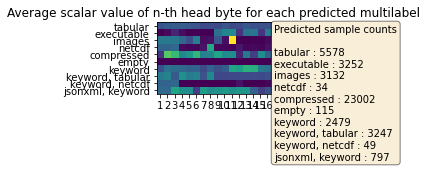

In [35]:
# Averaging the features for each bit

avgs = []
for key in large_dict.keys():
    lst = large_dict[key]
    lst = [list(x) for x in zip(*lst)]
    lst = [stats.mean(x) for x in lst]
    avgs.append(lst)
    
# UNCOMMENT to fill in empty labels in case you run on a limited range of samples

# for i in range(len(avgs)):
#     if (len(avgs[i])==0):
#         avgs[i] = [0.0] * byte_count

# Creating the plot

fig, ax1 = plt.subplots()

# Label y axis side with the class name

y1_axis_labels = large_dict.keys()
ax1.set_yticks(np.arange(len(y1_axis_labels)), labels=y1_axis_labels)

# Plot the heatmap set good x-axis ticks

fig.set_size_inches((2*byte_count)/10, 10.5) # UNCOMMENT FOR LARGER BYTECOUNTS
plt.imshow(np.array(avgs))
plt.xticks(ticks=[i for i in range(byte_count)], labels=[i+1 for i in range(byte_count)])

# Adding title and sample count legend

ax1.set_title("Average scalar value of n-th head byte for each predicted multilabel")
plt.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(byte_count, -0.25, sample_counts[:-1], fontsize=10,
         verticalalignment='top', bbox=props)

## Standard deviation heatmap

In [ ]:
# Finding the standard deviation for each bit

stdevs = []
y_axis_labels = []
for key in large_dict.keys():
    lst = large_dict[key]
    lst = [list(x) for x in zip(*lst)]
    if (len(lst[0])>1):
        lst = [stats.stdev(x) for x in lst]
        stdevs.append(lst)
        y_axis_labels.append(key)
    
# UNCOMMENT to fill in empty labels in case you run on a limited range of samples

# for i in range(len(stdevs)):
#     if (len(stdevs[i])==0):
#         stdevs[i] = [0.0] * byte_count

# Creating the plot

fig, ax = plt.subplots()
im = ax.imshow(np.array(stdevs))

# Show all ticks and label them with the respective list entries

ax.set_yticks(np.arange(len(y_axis_labels)), labels=y_axis_labels)

# Plot the heatmap set good x-axis ticks

fig.set_size_inches(18.5, 10.5) # UNCOMMENT FOR LARGER BYTECOUNTS
plt.imshow(np.array(stdevs))
plt.xticks(ticks=[i for i in range(byte_count)], labels=[i+1 for i in range(byte_count)])

# Adding title and sample count legend

ax1.set_title("Standard deviation of scalar values of n-th head byte")
plt.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(byte_count, -0.25, sample_counts[:-1], fontsize=10,
         verticalalignment='top', bbox=props)

# Multilabel Confusion Matrices
Acceptable classifiers: any

In [2]:
import pandas as pd
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

y_pred = classifier.model.predict(classifier.X_test)

## Individual Label Matrices

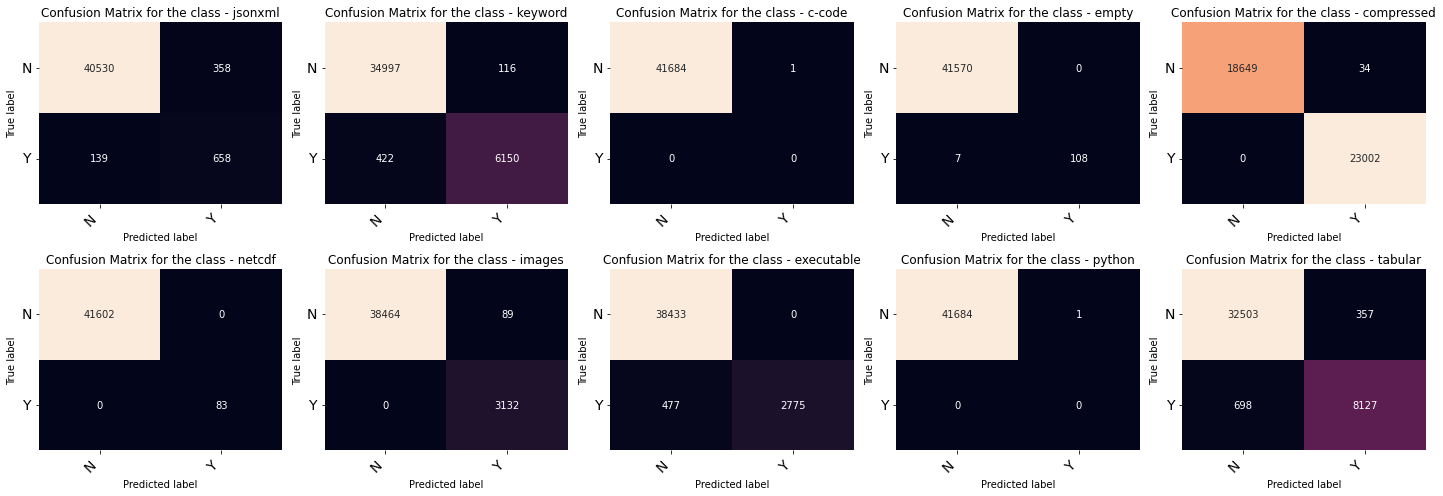

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Some customizable values here, first two values should multiply to at least label count
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
    
multilabel_confusion_matrix = multilabel_confusion_matrix(y_pred, classifier.Y_test)
multilabel_labels = classifier.unique_labels

for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix, multilabel_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Predicted Multilabel Matrices

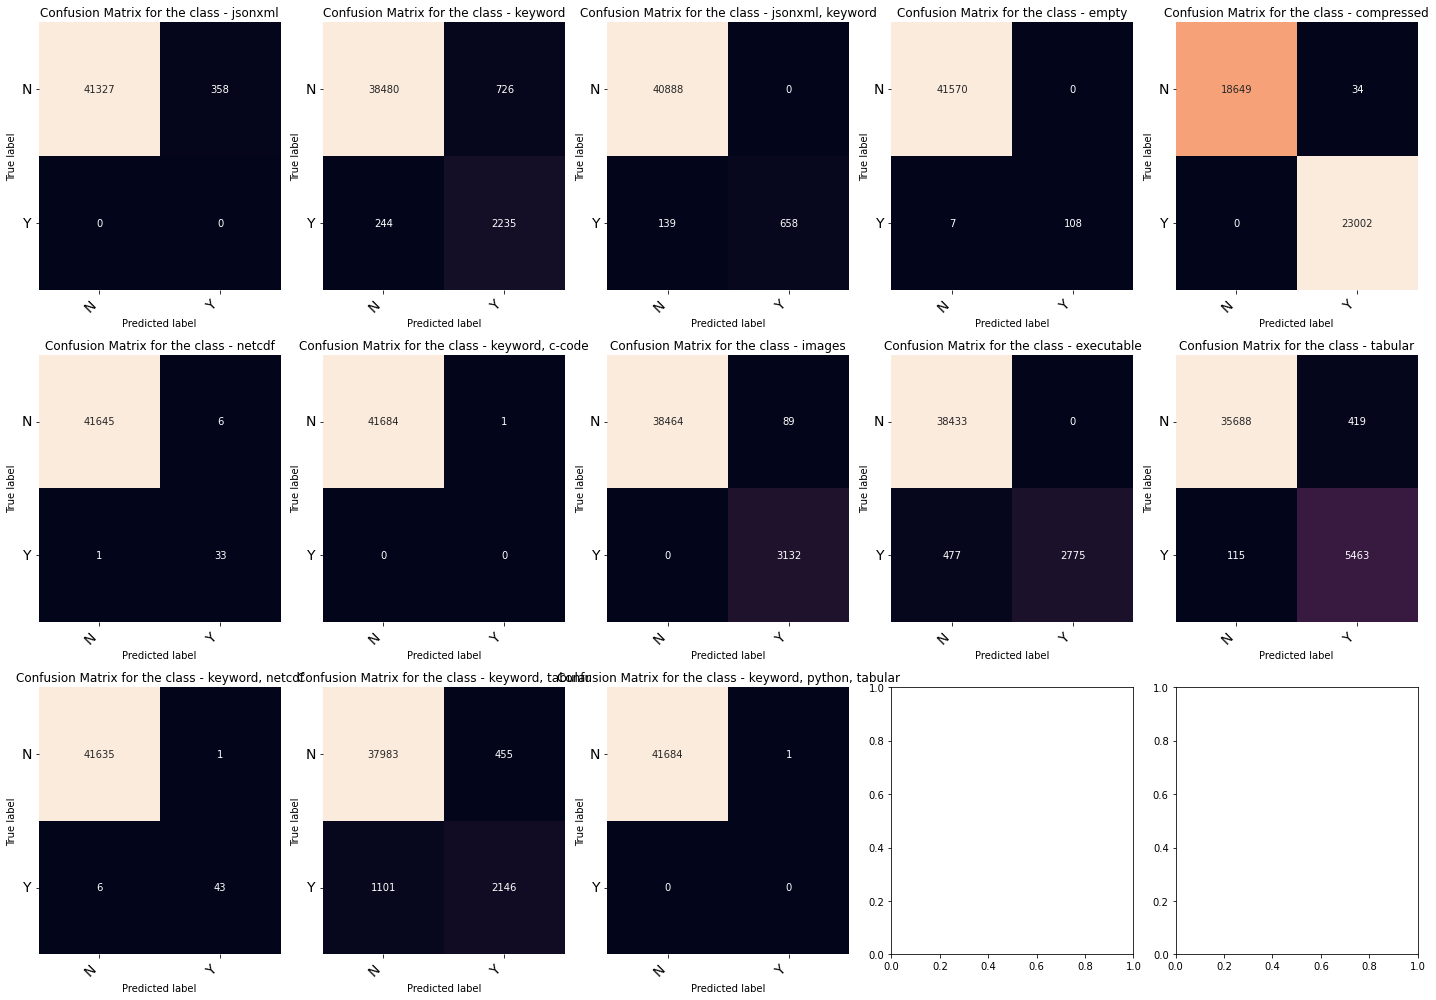

In [5]:
import sympy
import primefac
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

unique_rows = np.unique(np.concatenate([y_pred, classifier.Y_test]), axis=0)
row_hashtable = dict()

primes_master = []
for i in range(len(unique_rows[0])):
    primes_master.append(sympy.prime(i+1))
    
def row_hasher(row):
    primes = []
    hash_labels = []
    for i in range(len(row)):
        if row[i] == 1:
            primes.append(primes_master[i])
    return np.prod(primes)

y_pred = classifier.model.predict(classifier.X_test)
y_pred_hashed = []
Y_test_hashed = []

for i in range(len(y_pred)):
    y_pred_hashed.append(row_hasher(y_pred[i]))
    Y_test_hashed.append(row_hasher(classifier.Y_test[i]))

unique_hashes = np.unique(Y_test_hashed)
hash_to_multiclass_dict = dict()

for i in range(len(unique_hashes)):
    b = [0] * len(unique_hashes)
    b[i] = 1
    hash_to_multiclass_dict[unique_hashes[i]] = b
    
multiclass_y_pred = []
multiclass_Y_test = []

for i in range(len(y_pred)):
    curr_mc_ypred = hash_to_multiclass_dict[y_pred_hashed[i]]
    curr_mc_Ytest = hash_to_multiclass_dict[Y_test_hashed[i]]
    multiclass_y_pred.append(curr_mc_ypred)
    multiclass_Y_test.append(curr_mc_Ytest)

labels_gt_dict = dict()
for i in range(len(unique_rows)):
    currlabels = []
    for j in range(len(unique_rows[0])):
        if unique_rows[i][j] == 1:
            currlabels.append(classifier.unique_labels[j])
    labels_gt_dict[row_hasher(unique_rows[i])] = ", ".join(currlabels)
    
# Some customizable values here, first two values should multiply to at least label count
fig, ax = plt.subplots(3, 5, figsize=(20, 14))
    
multilabel_confusion_matrix = multilabel_confusion_matrix(multiclass_y_pred, multiclass_Y_test)
multilabel_labels = [val[1] for val in sorted(labels_gt_dict.items())]

for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix, multilabel_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

# Precision-Recall Curve
NOTE: This creates new test and train datasets and trains a new OneVsRest Classifier, so the imported classifier model is irrelevant

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

random_state = np.random.RandomState(0)

y = []
y.extend(classifier.Y_train)
y.extend(classifier.Y_test)

X = []
X.extend(classifier.X_train)
X.extend(classifier.X_test)

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=random_state
)

ovr_classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
ovr_classifier.fit(X_train, Y_train)
y_score = ovr_classifier.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")